# 第4週：傲慢與偏見情緒分析

本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量長條圖
    + 3.4 正負向情緒分數比例折線圖
    + 3.5 正負向情緒分數
    + 3.6 文字雲
    + 3.7 情緒代表字

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [19]:
# 安裝會使用到的套件
# %pip install wordcloud

In [20]:
from collections import Counter
import pandas as pd
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download("punkt") # 下載需要用到的語料庫

%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 150

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


## 2. 資料前處理
基本上在前一次上課的內容已經提過，本節課直接沿用前一次課程清理完成的文集結果。

### 2.1 資料蒐集
在後續的範例中，我們將使用PRIDE & PREJUDICE這本書來說明文字分析的技術。

In [21]:
book = open('../week3/raw_data/PRIDE & PREJUDICE.txt', mode='r', encoding="utf-8")
content = book.read()

將內文用DataFrame的格式儲存

In [22]:
content_dict = {'text': [content]}
content_df = pd.DataFrame(content_dict)
content_df

,text
0,﻿TPRIDE & PREJUDICE.\n\n\n\n\nCHAPTER I.\n\n\n...


### 2.2 斷句

使用jieba套件的斷詞函式來實作斷詞，並利用pandas套件將文件整理成我們要的格式。步驟解釋如下：

+ ```assign``` : 新增一個欄位「sentence」，值為content_df['text']進行nltk_sent_tokenize的結果

+ ```apply``` : 對欄位「text」中的每一筆資料應用nltk.sent_tokenize函式

+ ```explode``` : word_tokenize的結果為list，因此用explode將list裡的每個值變單獨一行

+ ```drop``` : 將欄位「text」刪除，axis=1為對縱軸操作(column)，axis=0為對橫軸操作(row)


***大家可以試著將explode()或drop()拿掉，看看結果有什麼變化***

In [23]:
content_df = content_df.assign(sentence = content_df['text'].apply(nltk.sent_tokenize)).explode('sentence').drop(['text'], axis=1)
content_df

,sentence
0,﻿TPRIDE & PREJUDICE.
0,CHAPTER I.
0,"It is a truth universally acknowledged, that a..."
0,However little known the feelings or views of ...
0,"""My dear Mr. Bennet,"" said his lady to him one..."
...,...
0,By Elizabeth's instructions she began to compr...
0,Lady Catherine was extremely indignant on the ...
0,"But at length, by Elizabeth's persuasion,\nhe ..."
0,"With the Gardiners, they were always on the mo..."


英文的文集段詞方式會以空白來斷詞，但有許多專有名詞、地名、人名、名詞片語等(ex.Natural Language Processing、United States、Lydia Bennet)屬於多個字組合才是完整的字詞，這類的字不應該在斷詞時被斷開，因此通常會使用底線來將這些應該合併的字連在一起，使這些字在做斷詞時不會被斷開。

In [24]:
content_df["sentence"] = content_df["sentence"].replace({'Mr ': 'Mr_', 'Mrs ': 'Mrs_'}, regex=True)

### 2.3 資料整理

使用re套件並用正規表達式比對出章節每個句子所屬的章節，並在DataFrame中新增一個章節(chapter)的欄位

In [25]:
def get_chapter_sentences(sentence): # 判斷句子中是否包含"CHAPTER"
    if re.search('CHAPTER', sentence) == None: 
        return 0
    else:
        return 1

content_df = content_df.assign(chapter = content_df['sentence'].apply(get_chapter_sentences).cumsum()) #cumsum: 累加函數
content_df

,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
0,CHAPTER I.,1
0,"It is a truth universally acknowledged, that a...",1
0,However little known the feelings or views of ...,1
0,"""My dear Mr. Bennet,"" said his lady to him one...",1
...,...,...
0,By Elizabeth's instructions she began to compr...,61
0,Lady Catherine was extremely indignant on the ...,61
0,"But at length, by Elizabeth's persuasion,\nhe ...",61
0,"With the Gardiners, they were always on the mo...",61


### 2.4 移除無意義字、標點符號
清除CHAPTER的句子，並將長度小於1的句子刪除<br>
清除文本中的標點符號、數字以及換行符號

In [26]:
# 刪除CHAPTER的列
content_df = content_df[~content_df["sentence"].str.contains("CHAPTER")]

# 刪除標點符號/數字/換行符號
content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', x))  #只留下英文字母和空格(包含換行符號)
content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格
# content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'\s+',' ', x)) 

# 刪除長度小於1的句子
content_df = content_df[~content_df["sentence"].str.len() < 1]

content_df

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_18650/670373627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', x))  #只留下英文字母和空格(包含換行符號)
/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_18650/670373627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格


,sentence,chapter
0,TPRIDE PREJUDICE,0
0,It is a truth universally acknowledged that a ...,1
0,However little known the feelings or views of ...,1
0,My dear Mr Bennet said his lady to him one day...,1
0,Mr Bennet replied that he had not,1
...,...,...
0,By Elizabeths instructions she began to compre...,61
0,Lady Catherine was extremely indignant on the ...,61
0,But at length by Elizabeths persuasion he was ...,61
0,With the Gardiners they were always on the mos...,61


### 2.5 斷詞
使用NLTK的斷詞函式word_tokenize進行斷詞，將DataFrame處理成一個row一個斷詞的結果

In [27]:
token_df = content_df.assign(token = content_df['sentence'].apply(nltk.word_tokenize)).explode('token')
token_df

,sentence,chapter,token
0,TPRIDE PREJUDICE,0,TPRIDE
0,TPRIDE PREJUDICE,0,PREJUDICE
0,It is a truth universally acknowledged that a ...,1,It
0,It is a truth universally acknowledged that a ...,1,is
0,It is a truth universally acknowledged that a ...,1,a
...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the
0,Darcy as well as Elizabeth really loved them a...,61,means
0,Darcy as well as Elizabeth really loved them a...,61,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting


### 2.6 字詞正規化

#### 2.6.1 大小寫轉換

一種簡單的正規化方式為統一大小寫的字母，這樣在計算詞頻(或其他的匯總)時會將拼法一樣的字合併計算。

In [28]:
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())
lowerWord_df

,sentence,chapter,token,word
0,TPRIDE PREJUDICE,0,TPRIDE,tpride
0,TPRIDE PREJUDICE,0,PREJUDICE,prejudice
0,It is a truth universally acknowledged that a ...,1,It,it
0,It is a truth universally acknowledged that a ...,1,is,is
0,It is a truth universally acknowledged that a ...,1,a,a
...,...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the,the
0,Darcy as well as Elizabeth really loved them a...,61,means,means
0,Darcy as well as Elizabeth really loved them a...,61,of,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting


#### 2.6.2 Stemming

Stemming是將資料使用字根的方式表達，也就是說會將後面的多餘的字尾去除掉，像是"ing"、複數型態等等的。這裡使用NLTK套件中的PorterStemmer來示範

In [29]:
# 初始化一個PorterStemmer的物件，並存在porter變數中
porter = PorterStemmer()
type(porter)

nltk.stem.porter.PorterStemmer

使用PorterStemmer將 PRIDE & PREJUDICE 的斷詞結果還原

In [30]:
# 小提醒：nltk許多function變數規定為字串，因此可以先將word轉為字串格式，以確保後續不會有錯誤
lowerWord_df['word'] = lowerWord_df['word'].astype(str)
stem_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].apply(porter.stem)).reset_index(drop=True)

stem_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
2,It is a truth universally acknowledged that a ...,1,It,it,it
3,It is a truth universally acknowledged that a ...,1,is,is,is
4,It is a truth universally acknowledged that a ...,1,a,a,a
...,...,...,...,...,...
121615,Darcy as well as Elizabeth really loved them a...,61,the,the,the
121616,Darcy as well as Elizabeth really loved them a...,61,means,means,mean
121617,Darcy as well as Elizabeth really loved them a...,61,of,of,of
121618,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting,unit


### 2.7 移除停用字
停用字(Stopwords)是指那些對於分析沒有用的字詞，通常在進行文字分析時我們會將其去除，以避免一些雜訊的產生。這裡我們使用了NLTK套件中所提供的英文停用字資料來進行移除停用字的依據。初次使用的時候可以用以下的程式來下載預設停用字、或者是可以加入一些自訂的停用字詞。

載入nltk中的停用字

In [31]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')

# 使用nltk的stop_words
stops = stopwords.words('english')

# 手動加入停用字
newStops = ['could', 'would', 'much', 'must']
stops.extend(newStops)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


而移除停用字的方式是依照條件來篩選資料：將df['token'] 沒有在停用字裡的字保留，這邊要特別注意的是要先做字詞的正規化(Text Normalization)，使用轉成小寫英文的token再來進行比對，否則有些字不會被去除。例如：I、Because...

In [32]:
noStop_df = stem_df[~stem_df['word'].isin(stops)]
noStop_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg
...,...,...,...,...,...
121606,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
121609,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring
121612,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir
121616,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


可以注意到資料筆數的變化，移除停用字之後大幅減少

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC情緒字典與清理完成的傲慢與偏見
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [33]:
# 讀取情緒字典
en_dict_path = "./dict/liwc/LIWC_EN.csv"
liwc_dict = pd.read_csv(en_dict_path)
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict

,word,sentiments
0,(:,affect
1,):,affect
2,:(,affect
3,:),affect
4,abandon,affect
...,...,...
3280,whine,sad
3281,whining,sad
3282,woe,sad
3283,worthless,sad


In [34]:
liwc_dict['sentiments'].value_counts()

sentiments
affect      1416
negative     745
positive     642
anger        230
sad          136
anx          116
Name: count, dtype: int64

>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [35]:
book_df = noStop_df.copy()
book_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg
...,...,...,...,...,...
121606,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
121609,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring
121612,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir
121616,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [36]:
book_liwc_df = pd.merge(book_df, liwc_dict, how = 'left')
book_liwc_df

,sentence,chapter,token,word,stem_token,sentiments
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,NaN
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NaN
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth,affect
3,It is a truth universally acknowledged that a ...,1,truth,truth,truth,positive
4,It is a truth universally acknowledged that a ...,1,universally,universally,univers,NaN
...,...,...,...,...,...,...
59875,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person,NaN
59876,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring,NaN
59877,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir,NaN
59878,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NaN


In [37]:
# 算出每章情緒總和(sentiment_count)

sentiment_count = pd.DataFrame(book_liwc_df.groupby(['chapter', 'sentiments']).size()).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count

,chapter,sentiments,size
3,1,negative,9
4,1,positive,38
8,2,negative,10
9,2,positive,20
14,3,negative,21
...,...,...,...
345,59,positive,106
350,60,negative,19
351,60,positive,57
356,61,negative,14


### 3.3 正負向情緒聲量長條圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [38]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
pos

,chapter,sentiments,size
4,1,positive,38
9,2,positive,20
15,3,positive,65
21,4,positive,56
27,5,positive,41
...,...,...,...
333,57,positive,31
339,58,positive,70
345,59,positive,106
351,60,positive,57


In [39]:
neg

,chapter,sentiments,size
3,1,negative,9
8,2,negative,10
14,3,negative,21
20,4,negative,15
26,5,negative,16
...,...,...,...
332,57,negative,17
338,58,negative,37
344,59,negative,42
350,60,negative,19


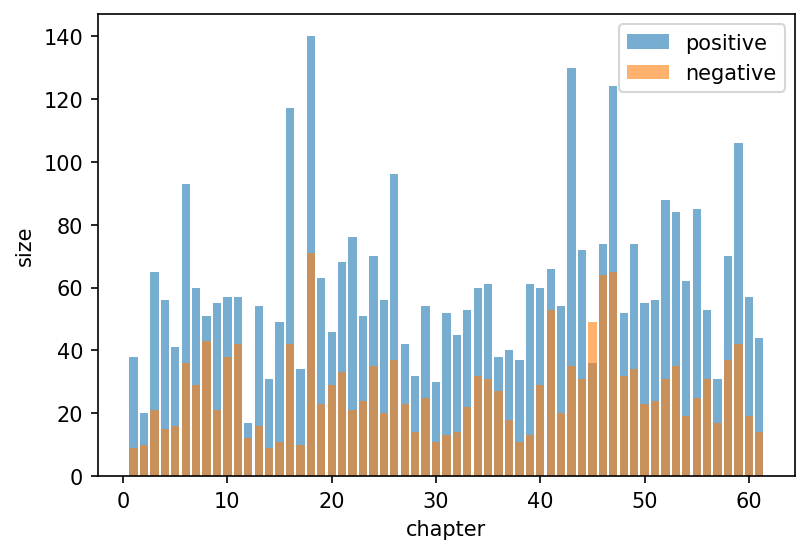

In [40]:
# you can find other color pattern here: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ["tab:blue",  "tab:orange"]
fig, ax = plt.subplots()

ax.bar(pos['chapter'],
       pos['size'],
       color = colors[0],
       alpha = 0.6,
       align='center')
ax.bar(neg['chapter'],
       neg['size'], 
       color = colors[1],
       alpha = 0.6,
       align='center')
plt.xlabel('chapter')
plt.ylabel('size')

ax.legend(['positive','negative'], loc ='upper right') 
plt.show()

In [41]:
pos.loc[pos['chapter'].isin(range(15,25))]

,chapter,sentiments,size
86,15,positive,49
92,16,positive,117
96,17,positive,34
102,18,positive,140
108,19,positive,63
114,20,positive,46
120,21,positive,68
126,22,positive,76
132,23,positive,51
138,24,positive,70


In [42]:
pos.loc[pos['chapter'].isin(range(40,45))]

,chapter,sentiments,size
231,40,positive,60
237,41,positive,66
243,42,positive,54
249,43,positive,130
255,44,positive,72


畫出每章的情緒總分數，可以看到正向情緒在 18 與 43 章較高

### 3.4 正負向情緒比例折線圖圖

In [43]:
sentiment_count[sentiment_count['chapter'] == 1]

,chapter,sentiments,size
3,1,negative,9
4,1,positive,38


In [44]:
sentiment_count.groupby('chapter')['size'].transform(lambda n : n/n.sum())

3      0.191489
4      0.808511
8      0.333333
9      0.666667
14     0.244186
         ...   
345    0.716216
350    0.250000
351    0.750000
356    0.241379
357    0.758621
Name: size, Length: 122, dtype: float64

In [45]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("chapter")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,chapter,sentiments,size,ratio
3,1,negative,9,0.191489
4,1,positive,38,0.808511
8,2,negative,10,0.333333
9,2,positive,20,0.666667
14,3,negative,21,0.244186
...,...,...,...,...
345,59,positive,106,0.716216
350,60,negative,19,0.250000
351,60,positive,57,0.750000
356,61,negative,14,0.241379


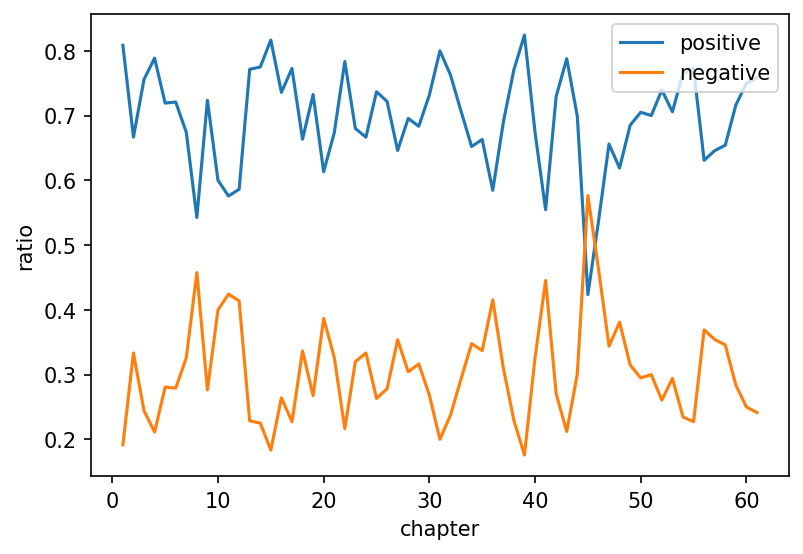

In [46]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
fig, ax = plt.subplots()

ax.plot(pos['chapter'],
       pos['ratio'],
       color = colors[0])
ax.plot(neg['chapter'],
       neg['ratio'], 
       color = colors[1])
plt.xlabel('chapter')
plt.ylabel('ratio')

ax.legend(['positive','negative'], loc ='upper right') 

### 3.5 正負向情緒分數

In [47]:
sentiment_count

,chapter,sentiments,size,ratio
3,1,negative,9,0.191489
4,1,positive,38,0.808511
8,2,negative,10,0.333333
9,2,positive,20,0.666667
14,3,negative,21,0.244186
...,...,...,...,...
345,59,positive,106,0.716216
350,60,negative,19,0.250000
351,60,positive,57,0.750000
356,61,negative,14,0.241379


In [48]:
mask = ~book_liwc_df['sentiments'].isna()
book_sentiment_value = sentiment_count.pivot_table(index='chapter', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
book_sentiment_value.head()

,chapter,negative,positive
0,1,9.0,38.0
1,2,10.0,20.0
2,3,21.0,65.0
3,4,15.0,56.0
4,5,16.0,41.0


In [49]:
# sentiment 計算方式: positive - anger - anx - negative - sad
book_sentiment_value["sentiment_value"] = (
    book_sentiment_value["positive"]
    - book_sentiment_value["negative"]
)
book_sentiment_value.head()

,chapter,negative,positive,sentiment_value
0,1,9.0,38.0,29.0
1,2,10.0,20.0,10.0
2,3,21.0,65.0,44.0
3,4,15.0,56.0,41.0
4,5,16.0,41.0,25.0


Text(0, 0.5, 'sentiment value')

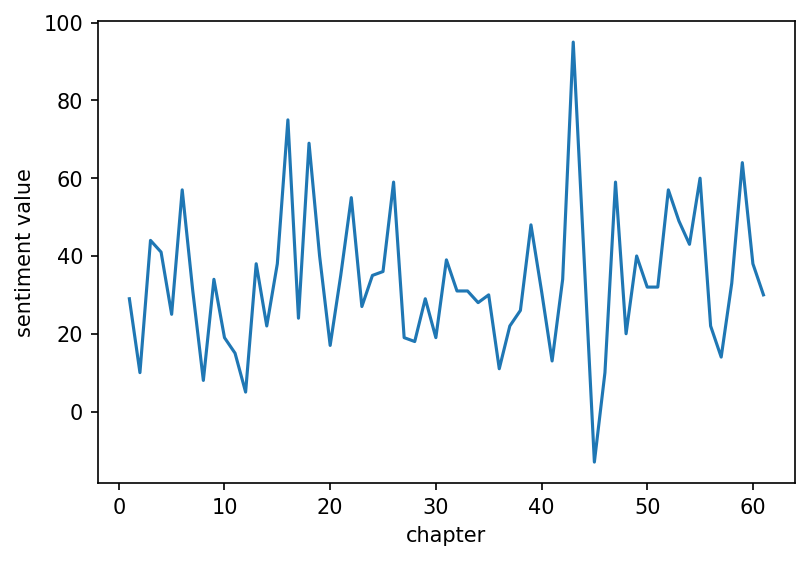

In [50]:
fig, ax = plt.subplots()
ax.plot(book_sentiment_value['chapter'], book_sentiment_value["sentiment_value"])
ax.set_xlabel('chapter')
ax.set_ylabel('sentiment value')

透過情緒分數趨勢圖，可以看出這本書中在不同的章節時，有明顯不同的情緒表現。

### 3.6 文字雲
針對不同章節畫出該章的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [51]:
# 先看看情緒分數最低的章節
book_sentiment_value.sort_values("sentiment_value", ascending=True)

,chapter,negative,positive,sentiment_value
44,45,49.0,36.0,-13.0
11,12,12.0,17.0,5.0
7,8,43.0,51.0,8.0
1,2,10.0,20.0,10.0
45,46,64.0,74.0,10.0
...,...,...,...,...
54,55,25.0,85.0,60.0
58,59,42.0,106.0,64.0
17,18,71.0,140.0,69.0
15,16,42.0,117.0,75.0


#### 第 45 章

In [52]:
book_liwc_df.head()

,sentence,chapter,token,word,stem_token,sentiments
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,NaN
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NaN
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth,affect
3,It is a truth universally acknowledged that a ...,1,truth,truth,truth,positive
4,It is a truth universally acknowledged that a ...,1,universally,universally,univers,NaN


In [53]:
## 篩選出 45 章且負向情緒的詞彙
mask = (book_liwc_df['chapter']==45) & (book_liwc_df['sentiments']=='negative')
book_tf_by_ch_df = book_liwc_df.loc[mask]
book_tf_by_ch_df.head()

,sentence,chapter,token,word,stem_token,sentiments
40842,Convinced as Elizabeth now was that Miss Bingl...,45,Miss,miss,miss,negative
40846,Convinced as Elizabeth now was that Miss Bingl...,45,dislike,dislike,dislik,negative
40849,Convinced as Elizabeth now was that Miss Bingl...,45,jealousy,jealousy,jealousi,negative
40896,In this room they were received by Miss Darcy ...,45,Miss,miss,miss,negative
40903,In this room they were received by Miss Darcy ...,45,Miss,miss,miss,negative


In [54]:
word_count_count = pd.DataFrame(book_tf_by_ch_df.groupby(['word']).size()).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
15,miss,21
10,feared,4
2,anxious,2
16,pain,2
12,jealousy,2
0,anger,1
13,longing,1
21,spite,1
20,sorry,1
19,shyness,1


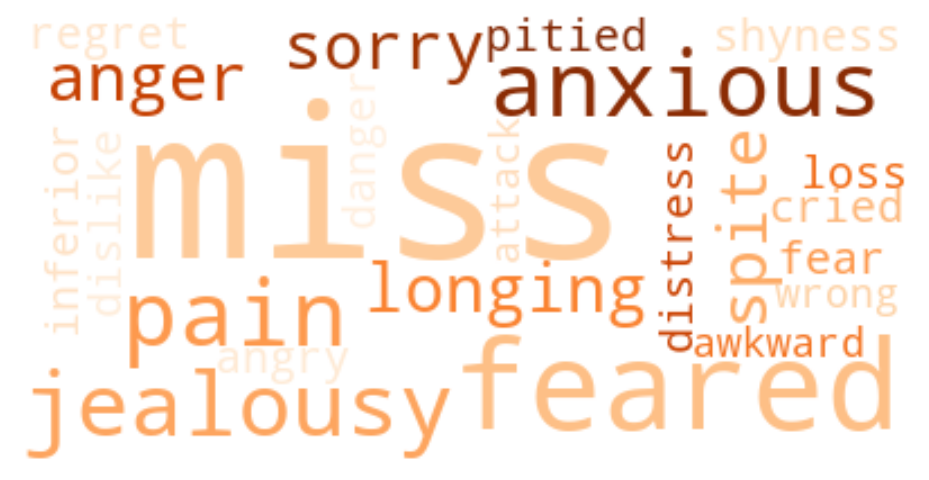

In [55]:
## wordcloud 的 input 是一個 dict, key是 word, value 是次數
cloud = WordCloud(max_words=200, background_color="white", colormap="Oranges")
wc_45 = dict(zip(word_count_count['word'], word_count_count['size']))
cloud.generate_from_frequencies(wc_45)
# 繪圖
# plt.figure(figsize=(10,5), dpi=300)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

第 45 章概要：

描述了伊麗莎白（主角）與其他訪客到賓格利莊園拜訪，見到達西小姐與其他親戚。伊麗莎白意識到賓格利小姐對她的嫉妒，達西小姐對她非常禮貌且害羞。達西先生出現後，被所有人注意，伊麗莎白努力保持冷靜。賓格利小姐不避諱對伊麗莎白的批評，達西先生則為伊麗莎白辯護。這段文字描繪了人物間的矛盾關係，尤其是賓格利小姐與伊麗莎白間的嫉妒，以及達西先生與伊麗莎白間潛在的親密關係。

可以看到文字雲中出現了 jealousy(嫉妒), dislike(不喜歡), awkward(尷尬), shyness(害羞) 等情緒關鍵字，反應了 45 章主要描述「社交場合中人與人之間的微妙互動，以及嫉妒、不滿、愛慕等情感可能如何影響人們的行為和關係。」

也因為本章節主要在描述以上內容，出現的負面情緒詞的比例比其他章節來得高。

### 3.7 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [56]:
word_count = book_liwc_df.groupby(['word', 'sentiments']).size().reset_index()
word_count.columns = ['word', 'sentiments','size']
word_count.sort_values("size", ascending=False)

,word,sentiments,size
638,miss,negative,281
637,miss,affect,281
639,miss,sad,281
1112,well,positive,211
1111,well,affect,211
...,...,...,...
557,kill,anger,1
912,splendor,positive,1
911,splendor,affect,1
558,kill,negative,1


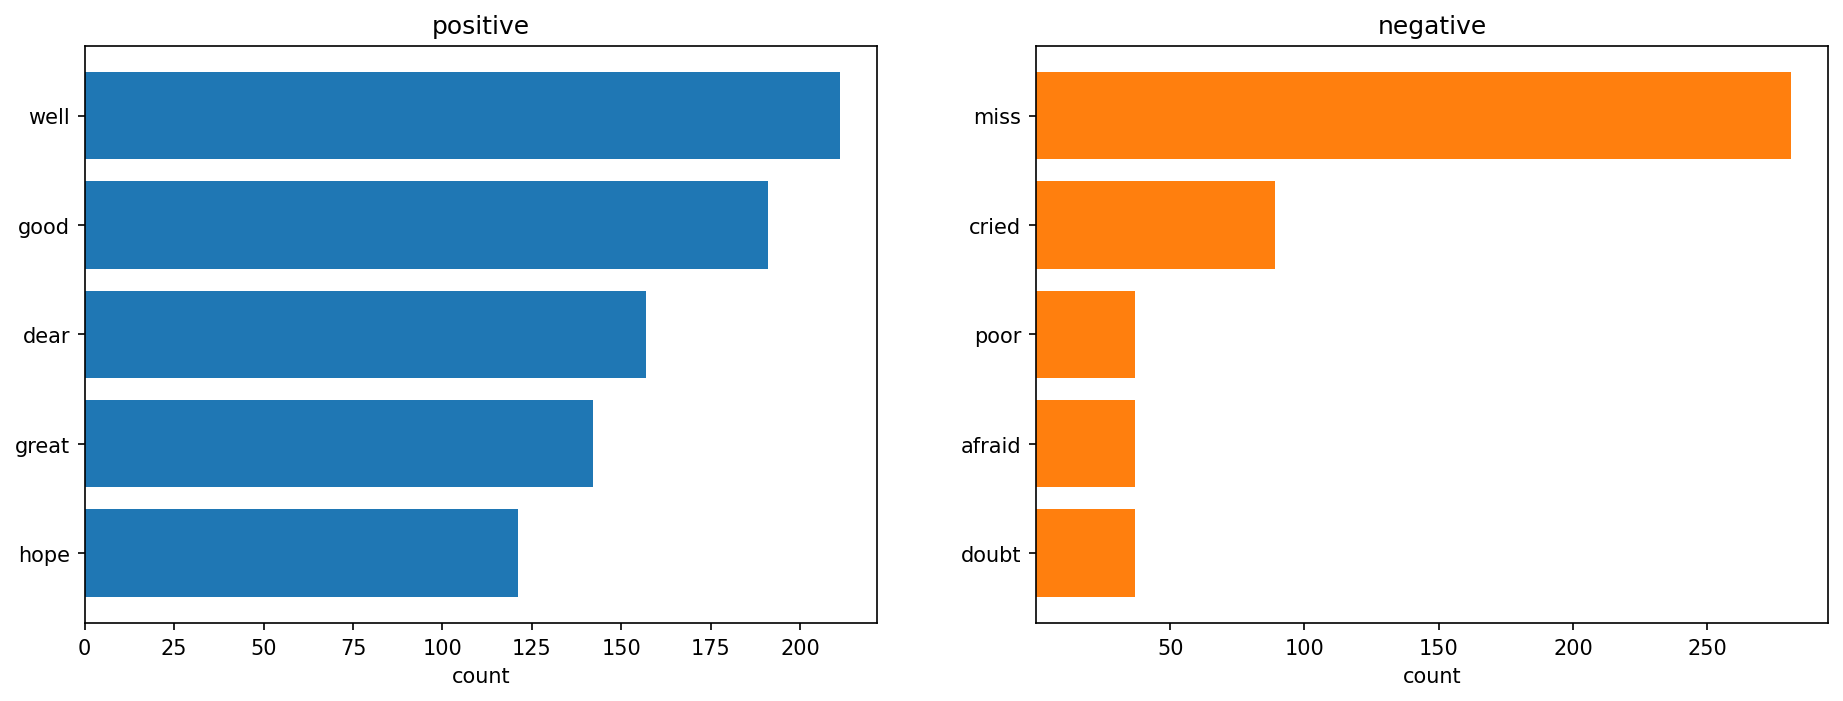

In [57]:
pos = word_count[word_count['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-5:]
neg = word_count[word_count['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-5:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[0].set_title("positive")

ax[1].xaxis.set_ticks([25,50,75,100,125,150,175]) 
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')
ax[1].set_title("negative")
ax[1].xaxis.set_ticks([50,100,150,200,250])

另外，也可以依據不同章節觀察情緒代表字的變化
#### ch.45 正負向情緒代表字

In [58]:
mask = (book_liwc_df['chapter']==45) & (~book_liwc_df['sentiments'].isna())
word_count_ch45 = book_liwc_df.loc[mask, ['word','sentiments']]
word_count_ch45 = word_count_ch45.groupby(['word', 'sentiments']).size().reset_index(name='size')
word_count_ch45.sort_values('size',ascending=False)

,word,sentiments,size
88,miss,affect,21
90,miss,sad,21
89,miss,negative,21
51,feared,negative,4
50,feared,anx,4
...,...,...,...
44,favour,affect,1
43,fair,positive,1
42,fair,affect,1
41,emotion,affect,1


Text(0.5, 0, 'count')

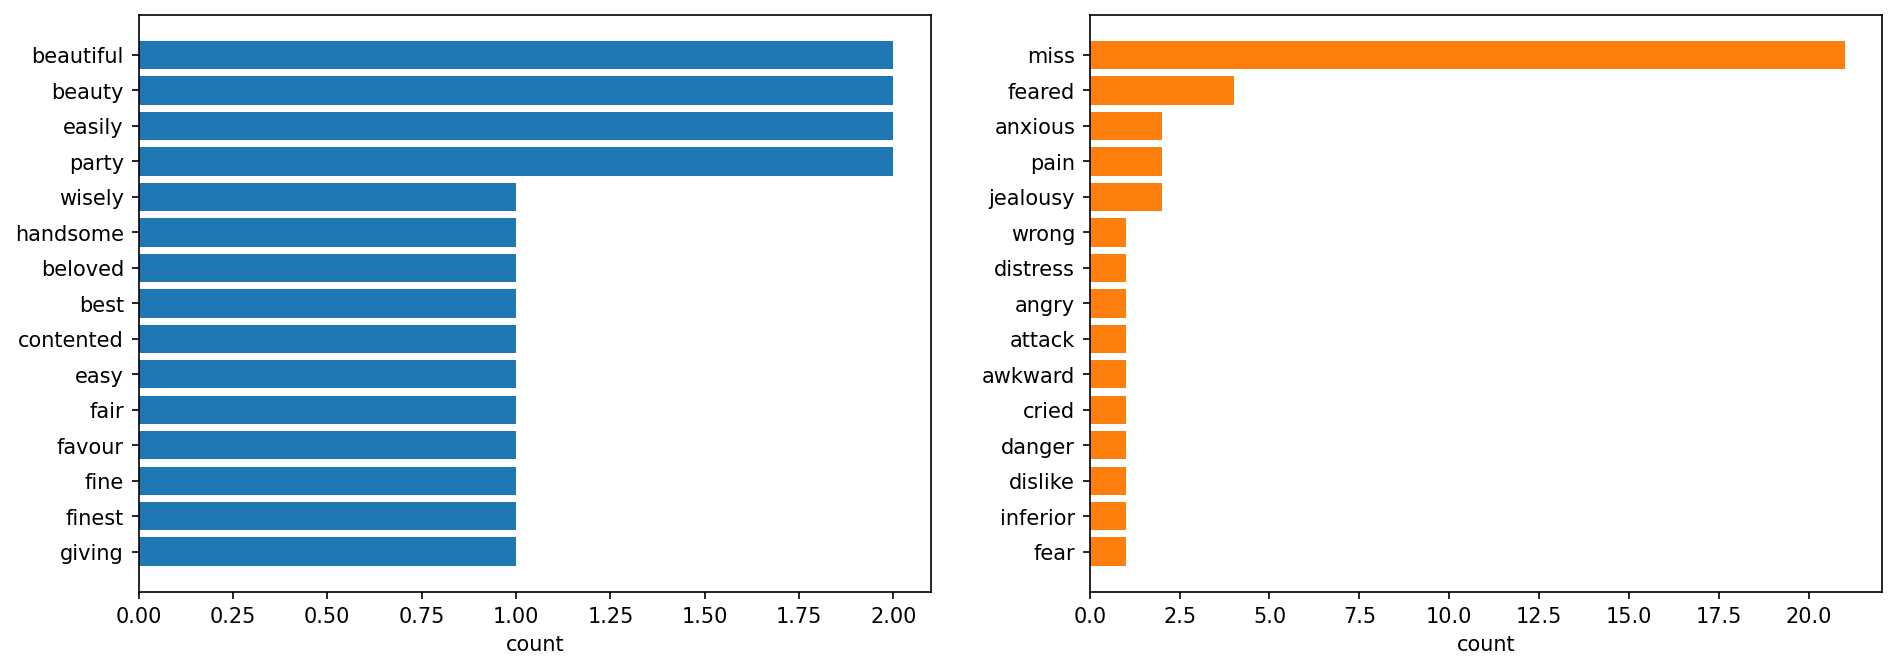

In [59]:
pos = word_count_ch45[word_count_ch45['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-15:]
neg = word_count_ch45[word_count_ch45['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-15:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')